# Tutorial

In this document, we'll show how to use this package, and compare the results to a frequentist, ad-hoc method of estimating the diffusion coefficient and its uncertainty.

In [1]:
%matplotlib inline

import Bayesian_Particle_Tracking
from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood, log_posterior, log_prior, diffusion
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.printable import Printable
from Bayesian_Particle_Tracking import generate_data
from Bayesian_Particle_Tracking.generate_data import data_generation, generator
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

We will use generated data so that it will be convenient for evaluating the validity of our method, since we will know the diffusion coefficient. For our parameters we choose $\sigma=10^{-8}$m, $\mu=10^{-4}$Pa\*s, $a=10^{-8}$m, $\tau = 1$s, where $\sigma$ is the measurement uncertainty on the particle's position, $\mu$ is the dynamic viscosity of the medium, $a$ is the radius of the particle, and $\tau$ is the time constant. the Our starting position is at the origin. We will look at a single particle over 10000 time frames or steps.

Note that from our parameters we are yielded a value of D by Stokes-Einstein:
$$D=\frac{k_bT}{6\pi\mu a}=2.19*10^{-10} m^2/s$$

In [53]:
#Generated the data with the following code. TODO: remove this but keep track of how data was generated
"""
#data = Bayesian_Particle_Tracking.generate_data.generator(1000000,10**(-8),10**(-4),10**(-8),[0,0,0])
#np.save('compare_data', data)

#compare_data = io.compare_data
#compare_input = io.compare_input
"""

home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/"
data = np.load(home_dir + 'compare_data.npy')
#Unnecessary, but I haven't checked the dependence of the other boxes on this variable 
compare_data = data
compare_input = diffusion(data)


To evaluate the diffusion coefficient we will be usinc Markov Chain Monte Carlo with the emcee package.

In [3]:
#the model has 1 parameter; we'll use 80 walkers and 500 steps
ndim = 1
nwalkers = 80
nsteps = 500

starting_positions = [10**(-10) + 1e-10*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[compare_input])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1min 15s, sys: 856 ms, total: 1min 16s
Wall time: 1min 20s
Done


Ploting our walkers:

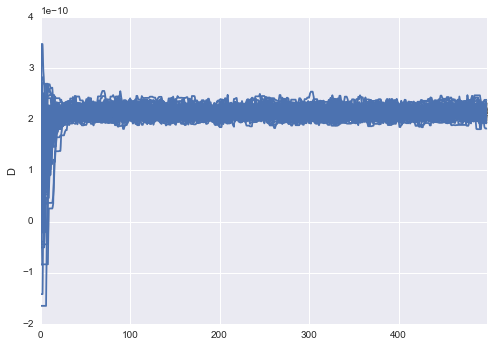

In [4]:
fig, (ax_D) = plt.subplots(1)
ax_D.set(ylabel='D')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_D)

This is a pretty fast burn in time. We'll cut out the first 75 steps.

In [5]:
samples = sampler.chain[:,75:,:]
# reshape the samples into a 1D array where the column is D
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'D': traces[0]})

Now let's plot the marginal pdf of D:

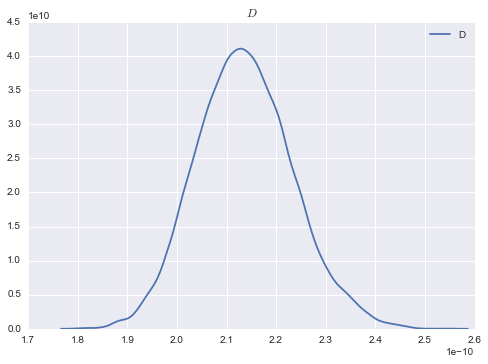

In [6]:
sns.kdeplot(parameter_samples['D'])
plt.title('$D$')

In [7]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("D = {:.12f} + {:.12f} - {:.12f}".format(q['D'][0.50], 
                                            q['D'][0.84]-q['D'][0.50],
                                            q['D'][0.50]-q['D'][0.16]))

D = 0.000000000213 + 0.000000000010 - 0.000000000009


This is very close to what we expect, and the true value of D is contained within our 68% credibility interval.

## Ad Hoc Method

This method is taken from Jerome Fung's 2013 doctoral dissertation at Harvard University, _Measuring the 3D Dynamics of Multiple Colloidal Particles_. The method, described as a "Flyvbjerg-Peterson (FB) algorithm" is described as follows:

1. Begin with correlated data (i.e., a set of squared displacements) $x_i$
2. Block-decorrelate the data (with Flybjerg-Peterson block-decorrelation). At each block decorrelation step, calculate var($x'_i$)/(N'-1)
3. To find the leftmost fixed-point region (smallest number of decorrelation setps), check if the variance estimate after $j$ transformations lies within the 1-sigma error bars of the variance estimate after j+1 transformations. The leftmost point to be considered fixed is the first point satisfying this criterior.
4. Repeat Step 3 from the right to find the rightmost edge of the fixed point region.
5. Compute a weighted average of all the var($x'_i$)/(N'-1) in the fixed-point region, where the weights by the 1-sigma error bars.

In [84]:
def MSD(data):
    data_length = len(data)
    point_before = list(data)
    del point_before[len(point_before)-1]
    point_before = np.array(point_before)
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]

    data_points = list(data)
    del data_points[0]
    data_points = np.array(data_points)
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)
    #return (np.sum(distance**2))/data_length
    return distance**2

1.3123351298215743e-09

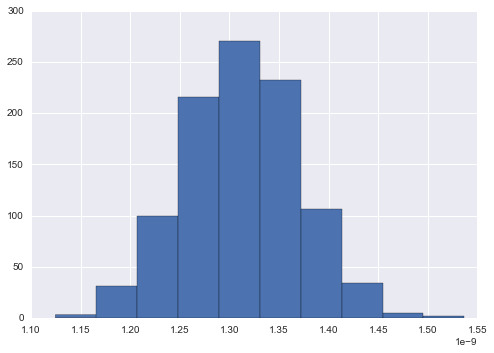

In [9]:
test_data = np.split(data,1000)
msd_array = np.array(list(map(MSD,test_data)))
plt.hist(msd_array)
np.median(msd_array)

# TODO:

Verify that the calculations for the variance of the mean and that uncertainty on the variance is correct.

In [142]:
#msd_array = np.array(list(map(MSD,test_data)))
msd_array = MSD(data)
new_length = len(msd_array)

output_var = []
var_uncertainty = []

for i in range(0,10):
    #length of the next array should be 2 times smalller (2^(i+1) times smaller overall)
    new_length = len(msd_array)/2
    new_array = np.zeros(new_length)
    #iterate over each element of the new array
    for i in range(0,len(new_array)):
        #Each element is given by the average of the corresponding 2 elements in the previous array
        new_array[i] = (msd_array[2*i-1]+msd_array[2*i])/2
    output_var.append(np.var(new_array)/(len(new_array)-1))
    var_uncertainty.append(np.var(new_array)/(len(new_array)-1)*np.sqrt(2/(len(new_array)-1)))
    msd_array = new_array
            
print(output_var)
print(var_uncertainty)

[3.4552955911492821e-24, 3.4656718227545569e-24, 3.4418817765573861e-24, 3.4663893511485362e-24, 3.4744195127772487e-24, 3.4835857583812531e-24, 3.4350405225198859e-24, 3.4197149188581021e-24, 3.4745396229154748e-24, 3.4786165716144506e-24]
[6.9106050035223933e-27, 9.8024393987835745e-27, 1.3767637247768095e-26, 1.9609173080719038e-26, 2.7796245596309204e-26, 3.9414796429238397e-26, 5.4965925342458344e-26, 7.7391699145815384e-26, 1.1121730313032958e-25, 1.5755030618535408e-25]


/Users/alanzhou/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alanzhou/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


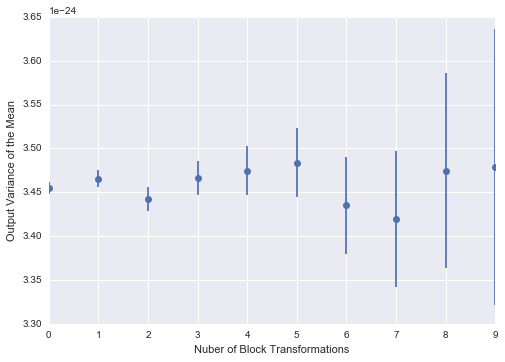

In [153]:
b = np.arange(0,len(output_var))
plt.errorbar(b,output_var, yerr = var_uncertainty, fmt='o')
plt.ylabel('Output Variance of the Mean')
plt.xlabel('Nuber of Block Transformations')

We can see that from the FP method, we should take the average of points 3 through 5 to find the variance on the sample mean.

In [156]:
np.mean(np.sqrt(var_uncertainty[3:6]))

1.6842880622265453e-13

We see that from the FP method we obtain a 68% confidence interval (1-sigma) of $1.7*10^{-13}$